# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 891us/sample - loss: 265.3155 - y1_output_loss: 122.9498 - y2_output_loss: 139.9153 - y1_output_root_mean_squared_error: 11.1411 - y2_output_root_mean_squared_error: 11.8824 - val_loss: 39.4847 - val_y1_output_loss: 20.6979 - val_y2_output_loss: 19.7951 - val_y1_output_root_mean_squared_error: 4.5341 - val_y2_output_root_mean_squared_error: 4.3504
Epoch 2/500
614/614 [==============================] - 0s 158us/sample - loss: 40.0160 - y1_output_loss: 13.9886 - y2_output_loss: 26.0503 - y1_output_root_mean_squared_error: 3.7469 - y2_output_root_mean_squared_error: 5.0967 - val_loss: 42.2492 - val_y1_output_loss: 17.7285 - val_y2_output_loss: 26.0223 - val_y1_output_root_mean_squared_error: 4.1733 - val_y2_output_root_mean_squared_error: 4.9833
Epoch 3/500
614/614 [==============================] - 0s 131us/sample - loss: 30.1946 - y1_output_loss: 11.3347 - y2_output_loss: 18.8308 - y1

614/614 [==============================] - 0s 128us/sample - loss: 12.3307 - y1_output_loss: 4.9365 - y2_output_loss: 7.3539 - y1_output_root_mean_squared_error: 2.2284 - y2_output_root_mean_squared_error: 2.7138 - val_loss: 16.5047 - val_y1_output_loss: 5.1613 - val_y2_output_loss: 11.7451 - val_y1_output_root_mean_squared_error: 2.2696 - val_y2_output_root_mean_squared_error: 3.3695
Epoch 22/500
614/614 [==============================] - 0s 126us/sample - loss: 12.6344 - y1_output_loss: 4.7211 - y2_output_loss: 7.8429 - y1_output_root_mean_squared_error: 2.1805 - y2_output_root_mean_squared_error: 2.8071 - val_loss: 9.5224 - val_y1_output_loss: 4.3530 - val_y2_output_loss: 5.3368 - val_y1_output_root_mean_squared_error: 2.0984 - val_y2_output_root_mean_squared_error: 2.2626
Epoch 23/500
614/614 [==============================] - 0s 130us/sample - loss: 13.7030 - y1_output_loss: 5.0979 - y2_output_loss: 8.5380 - y1_output_root_mean_squared_error: 2.2630 - y2_output_root_mean_squared_e

614/614 [==============================] - 0s 130us/sample - loss: 7.4589 - y1_output_loss: 2.4630 - y2_output_loss: 4.9408 - y1_output_root_mean_squared_error: 1.5750 - y2_output_root_mean_squared_error: 2.2312 - val_loss: 5.7829 - val_y1_output_loss: 2.2762 - val_y2_output_loss: 3.5277 - val_y1_output_root_mean_squared_error: 1.5294 - val_y2_output_root_mean_squared_error: 1.8558
Epoch 42/500
614/614 [==============================] - 0s 127us/sample - loss: 7.5277 - y1_output_loss: 2.4250 - y2_output_loss: 5.0620 - y1_output_root_mean_squared_error: 1.5591 - y2_output_root_mean_squared_error: 2.2576 - val_loss: 7.7326 - val_y1_output_loss: 2.9723 - val_y2_output_loss: 5.1451 - val_y1_output_root_mean_squared_error: 1.7067 - val_y2_output_root_mean_squared_error: 2.1954
Epoch 43/500
614/614 [==============================] - 0s 130us/sample - loss: 6.0343 - y1_output_loss: 1.9568 - y2_output_loss: 4.0379 - y1_output_root_mean_squared_error: 1.4022 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 128us/sample - loss: 4.6272 - y1_output_loss: 1.2872 - y2_output_loss: 3.3419 - y1_output_root_mean_squared_error: 1.1375 - y2_output_root_mean_squared_error: 1.8257 - val_loss: 7.9113 - val_y1_output_loss: 1.8943 - val_y2_output_loss: 6.2696 - val_y1_output_root_mean_squared_error: 1.3625 - val_y2_output_root_mean_squared_error: 2.4607
Epoch 63/500
614/614 [==============================] - 0s 133us/sample - loss: 4.6520 - y1_output_loss: 1.3657 - y2_output_loss: 3.2824 - y1_output_root_mean_squared_error: 1.1582 - y2_output_root_mean_squared_error: 1.8195 - val_loss: 4.8388 - val_y1_output_loss: 1.9285 - val_y2_output_loss: 2.8873 - val_y1_output_root_mean_squared_error: 1.4045 - val_y2_output_root_mean_squared_error: 1.6930
Epoch 64/500
614/614 [==============================] - 0s 133us/sample - loss: 4.8427 - y1_output_loss: 1.4606 - y2_output_loss: 3.3847 - y1_output_root_mean_squared_error: 1.2106 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 133us/sample - loss: 3.5540 - y1_output_loss: 0.8844 - y2_output_loss: 2.6450 - y1_output_root_mean_squared_error: 0.9404 - y2_output_root_mean_squared_error: 1.6339 - val_loss: 2.6533 - val_y1_output_loss: 0.6606 - val_y2_output_loss: 1.9725 - val_y1_output_root_mean_squared_error: 0.8094 - val_y2_output_root_mean_squared_error: 1.4136
Epoch 84/500
614/614 [==============================] - 0s 127us/sample - loss: 2.7963 - y1_output_loss: 0.7293 - y2_output_loss: 2.0849 - y1_output_root_mean_squared_error: 0.8484 - y2_output_root_mean_squared_error: 1.4410 - val_loss: 9.5254 - val_y1_output_loss: 2.6387 - val_y2_output_loss: 7.0193 - val_y1_output_root_mean_squared_error: 1.6157 - val_y2_output_root_mean_squared_error: 2.6297
Epoch 85/500
614/614 [==============================] - 0s 129us/sample - loss: 3.0960 - y1_output_loss: 0.7948 - y2_output_loss: 2.2978 - y1_output_root_mean_squared_error: 0.8954 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 132us/sample - loss: 2.9518 - y1_output_loss: 0.6676 - y2_output_loss: 2.2605 - y1_output_root_mean_squared_error: 0.8201 - y2_output_root_mean_squared_error: 1.5097 - val_loss: 1.9785 - val_y1_output_loss: 0.5042 - val_y2_output_loss: 1.4790 - val_y1_output_root_mean_squared_error: 0.6977 - val_y2_output_root_mean_squared_error: 1.2214
Epoch 105/500
614/614 [==============================] - 0s 128us/sample - loss: 2.1762 - y1_output_loss: 0.4963 - y2_output_loss: 1.6968 - y1_output_root_mean_squared_error: 0.7051 - y2_output_root_mean_squared_error: 1.2958 - val_loss: 4.9529 - val_y1_output_loss: 1.1748 - val_y2_output_loss: 3.7525 - val_y1_output_root_mean_squared_error: 1.0930 - val_y2_output_root_mean_squared_error: 1.9386
Epoch 106/500
614/614 [==============================] - 0s 129us/sample - loss: 3.5571 - y1_output_loss: 0.8795 - y2_output_loss: 2.6504 - y1_output_root_mean_squared_error: 0.9408 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 1.8711 - y1_output_loss: 0.4297 - y2_output_loss: 1.4658 - y1_output_root_mean_squared_error: 0.6572 - y2_output_root_mean_squared_error: 1.1997 - val_loss: 4.2029 - val_y1_output_loss: 1.0092 - val_y2_output_loss: 3.3076 - val_y1_output_root_mean_squared_error: 0.9971 - val_y2_output_root_mean_squared_error: 1.7913
Epoch 125/500
614/614 [==============================] - 0s 130us/sample - loss: 7.1212 - y1_output_loss: 2.0443 - y2_output_loss: 5.0310 - y1_output_root_mean_squared_error: 1.4356 - y2_output_root_mean_squared_error: 2.2495 - val_loss: 3.6424 - val_y1_output_loss: 0.8093 - val_y2_output_loss: 2.8574 - val_y1_output_root_mean_squared_error: 0.8975 - val_y2_output_root_mean_squared_error: 1.6843
Epoch 126/500
614/614 [==============================] - 0s 127us/sample - loss: 2.3020 - y1_output_loss: 0.5736 - y2_output_loss: 1.7378 - y1_output_root_mean_squared_error: 0.7593 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 127us/sample - loss: 2.4959 - y1_output_loss: 0.6432 - y2_output_loss: 1.8577 - y1_output_root_mean_squared_error: 0.8029 - y2_output_root_mean_squared_error: 1.3606 - val_loss: 3.1441 - val_y1_output_loss: 0.5941 - val_y2_output_loss: 2.5283 - val_y1_output_root_mean_squared_error: 0.7796 - val_y2_output_root_mean_squared_error: 1.5926
Epoch 146/500
614/614 [==============================] - 0s 123us/sample - loss: 1.5741 - y1_output_loss: 0.3004 - y2_output_loss: 1.2698 - y1_output_root_mean_squared_error: 0.5495 - y2_output_root_mean_squared_error: 1.1279 - val_loss: 1.6145 - val_y1_output_loss: 0.3645 - val_y2_output_loss: 1.2263 - val_y1_output_root_mean_squared_error: 0.6093 - val_y2_output_root_mean_squared_error: 1.1150
Epoch 147/500
614/614 [==============================] - 0s 124us/sample - loss: 1.7492 - y1_output_loss: 0.3208 - y2_output_loss: 1.4151 - y1_output_root_mean_squared_error: 0.5683 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 1.3751 - y1_output_loss: 0.2894 - y2_output_loss: 1.0902 - y1_output_root_mean_squared_error: 0.5344 - y2_output_root_mean_squared_error: 1.0438 - val_loss: 1.9896 - val_y1_output_loss: 0.5465 - val_y2_output_loss: 1.4197 - val_y1_output_root_mean_squared_error: 0.7462 - val_y2_output_root_mean_squared_error: 1.1970
Epoch 166/500
614/614 [==============================] - 0s 132us/sample - loss: 1.5237 - y1_output_loss: 0.3358 - y2_output_loss: 1.1816 - y1_output_root_mean_squared_error: 0.5800 - y2_output_root_mean_squared_error: 1.0896 - val_loss: 1.8162 - val_y1_output_loss: 0.4354 - val_y2_output_loss: 1.3735 - val_y1_output_root_mean_squared_error: 0.6670 - val_y2_output_root_mean_squared_error: 1.1710
Epoch 167/500
614/614 [==============================] - 0s 131us/sample - loss: 1.4121 - y1_output_loss: 0.2905 - y2_output_loss: 1.1239 - y1_output_root_mean_squared_error: 0.5397 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 122us/sample - loss: 1.3727 - y1_output_loss: 0.2988 - y2_output_loss: 1.0700 - y1_output_root_mean_squared_error: 0.5479 - y2_output_root_mean_squared_error: 1.0356 - val_loss: 1.9277 - val_y1_output_loss: 0.3173 - val_y2_output_loss: 1.6943 - val_y1_output_root_mean_squared_error: 0.5606 - val_y2_output_root_mean_squared_error: 1.2702
Epoch 187/500
614/614 [==============================] - 0s 130us/sample - loss: 1.3082 - y1_output_loss: 0.2549 - y2_output_loss: 1.0422 - y1_output_root_mean_squared_error: 0.5070 - y2_output_root_mean_squared_error: 1.0253 - val_loss: 1.5400 - val_y1_output_loss: 0.2941 - val_y2_output_loss: 1.2556 - val_y1_output_root_mean_squared_error: 0.5444 - val_y2_output_root_mean_squared_error: 1.1152
Epoch 188/500
614/614 [==============================] - 0s 137us/sample - loss: 1.0437 - y1_output_loss: 0.2343 - y2_output_loss: 0.8040 - y1_output_root_mean_squared_error: 0.4841 - y2_output_root_mea

614/614 [==============================] - 0s 126us/sample - loss: 1.1797 - y1_output_loss: 0.2892 - y2_output_loss: 0.8899 - y1_output_root_mean_squared_error: 0.5398 - y2_output_root_mean_squared_error: 0.9425 - val_loss: 1.3566 - val_y1_output_loss: 0.3185 - val_y2_output_loss: 1.0651 - val_y1_output_root_mean_squared_error: 0.5711 - val_y2_output_root_mean_squared_error: 1.0151
Epoch 207/500
614/614 [==============================] - 0s 128us/sample - loss: 1.1208 - y1_output_loss: 0.2546 - y2_output_loss: 0.8688 - y1_output_root_mean_squared_error: 0.5049 - y2_output_root_mean_squared_error: 0.9305 - val_loss: 1.2940 - val_y1_output_loss: 0.2974 - val_y2_output_loss: 0.9911 - val_y1_output_root_mean_squared_error: 0.5472 - val_y2_output_root_mean_squared_error: 0.9973
Epoch 208/500
614/614 [==============================] - 0s 126us/sample - loss: 1.0975 - y1_output_loss: 0.2252 - y2_output_loss: 0.8757 - y1_output_root_mean_squared_error: 0.4743 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9139 - y1_output_loss: 0.2004 - y2_output_loss: 0.7101 - y1_output_root_mean_squared_error: 0.4490 - y2_output_root_mean_squared_error: 0.8440 - val_loss: 1.1210 - val_y1_output_loss: 0.2327 - val_y2_output_loss: 0.9023 - val_y1_output_root_mean_squared_error: 0.4842 - val_y2_output_root_mean_squared_error: 0.9416
Epoch 228/500
614/614 [==============================] - 0s 142us/sample - loss: 1.0458 - y1_output_loss: 0.2314 - y2_output_loss: 0.8218 - y1_output_root_mean_squared_error: 0.4764 - y2_output_root_mean_squared_error: 0.9049 - val_loss: 1.0142 - val_y1_output_loss: 0.2376 - val_y2_output_loss: 0.7832 - val_y1_output_root_mean_squared_error: 0.4916 - val_y2_output_root_mean_squared_error: 0.8790
Epoch 229/500
614/614 [==============================] - 0s 129us/sample - loss: 0.9012 - y1_output_loss: 0.2283 - y2_output_loss: 0.6650 - y1_output_root_mean_squared_error: 0.4797 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 0.7197 - y1_output_loss: 0.1710 - y2_output_loss: 0.5430 - y1_output_root_mean_squared_error: 0.4143 - y2_output_root_mean_squared_error: 0.7403 - val_loss: 1.1532 - val_y1_output_loss: 0.3465 - val_y2_output_loss: 0.8082 - val_y1_output_root_mean_squared_error: 0.5921 - val_y2_output_root_mean_squared_error: 0.8959
Epoch 248/500
614/614 [==============================] - 0s 128us/sample - loss: 1.0529 - y1_output_loss: 0.2252 - y2_output_loss: 0.8195 - y1_output_root_mean_squared_error: 0.4757 - y2_output_root_mean_squared_error: 0.9092 - val_loss: 1.0346 - val_y1_output_loss: 0.2469 - val_y2_output_loss: 0.7907 - val_y1_output_root_mean_squared_error: 0.4899 - val_y2_output_root_mean_squared_error: 0.8914
Epoch 249/500
614/614 [==============================] - 0s 128us/sample - loss: 0.6812 - y1_output_loss: 0.1540 - y2_output_loss: 0.5211 - y1_output_root_mean_squared_error: 0.3941 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 130us/sample - loss: 0.8195 - y1_output_loss: 0.2036 - y2_output_loss: 0.6138 - y1_output_root_mean_squared_error: 0.4522 - y2_output_root_mean_squared_error: 0.7842 - val_loss: 1.3710 - val_y1_output_loss: 0.3609 - val_y2_output_loss: 1.0328 - val_y1_output_root_mean_squared_error: 0.5996 - val_y2_output_root_mean_squared_error: 1.0058
Epoch 269/500
614/614 [==============================] - 0s 129us/sample - loss: 1.0109 - y1_output_loss: 0.2334 - y2_output_loss: 0.7902 - y1_output_root_mean_squared_error: 0.4842 - y2_output_root_mean_squared_error: 0.8812 - val_loss: 1.9808 - val_y1_output_loss: 0.3242 - val_y2_output_loss: 1.7461 - val_y1_output_root_mean_squared_error: 0.5650 - val_y2_output_root_mean_squared_error: 1.2890
Epoch 270/500
614/614 [==============================] - 0s 129us/sample - loss: 1.1496 - y1_output_loss: 0.2557 - y2_output_loss: 0.8849 - y1_output_root_mean_squared_error: 0.5077 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.7090 - y1_output_loss: 0.1576 - y2_output_loss: 0.5479 - y1_output_root_mean_squared_error: 0.3972 - y2_output_root_mean_squared_error: 0.7424 - val_loss: 1.4188 - val_y1_output_loss: 0.3818 - val_y2_output_loss: 1.0262 - val_y1_output_root_mean_squared_error: 0.6142 - val_y2_output_root_mean_squared_error: 1.0205
Epoch 289/500
614/614 [==============================] - 0s 124us/sample - loss: 0.6558 - y1_output_loss: 0.1466 - y2_output_loss: 0.5050 - y1_output_root_mean_squared_error: 0.3838 - y2_output_root_mean_squared_error: 0.7131 - val_loss: 0.9037 - val_y1_output_loss: 0.1996 - val_y2_output_loss: 0.7026 - val_y1_output_root_mean_squared_error: 0.4457 - val_y2_output_root_mean_squared_error: 0.8397
Epoch 290/500
614/614 [==============================] - 0s 138us/sample - loss: 0.9964 - y1_output_loss: 0.2290 - y2_output_loss: 0.7704 - y1_output_root_mean_squared_error: 0.4798 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 135us/sample - loss: 0.5630 - y1_output_loss: 0.1427 - y2_output_loss: 0.4196 - y1_output_root_mean_squared_error: 0.3760 - y2_output_root_mean_squared_error: 0.6493 - val_loss: 1.7729 - val_y1_output_loss: 0.6561 - val_y2_output_loss: 1.0956 - val_y1_output_root_mean_squared_error: 0.8167 - val_y2_output_root_mean_squared_error: 1.0517
Epoch 310/500
614/614 [==============================] - 0s 132us/sample - loss: 0.7405 - y1_output_loss: 0.1821 - y2_output_loss: 0.5583 - y1_output_root_mean_squared_error: 0.4276 - y2_output_root_mean_squared_error: 0.7468 - val_loss: 1.3665 - val_y1_output_loss: 0.2554 - val_y2_output_loss: 1.0971 - val_y1_output_root_mean_squared_error: 0.5053 - val_y2_output_root_mean_squared_error: 1.0541
Epoch 311/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6840 - y1_output_loss: 0.1626 - y2_output_loss: 0.5191 - y1_output_root_mean_squared_error: 0.4044 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 0.5223 - y1_output_loss: 0.1394 - y2_output_loss: 0.3870 - y1_output_root_mean_squared_error: 0.3742 - y2_output_root_mean_squared_error: 0.6183 - val_loss: 1.7749 - val_y1_output_loss: 0.3114 - val_y2_output_loss: 1.4768 - val_y1_output_root_mean_squared_error: 0.5527 - val_y2_output_root_mean_squared_error: 1.2122
Epoch 330/500
614/614 [==============================] - 0s 127us/sample - loss: 0.5582 - y1_output_loss: 0.1293 - y2_output_loss: 0.4303 - y1_output_root_mean_squared_error: 0.3559 - y2_output_root_mean_squared_error: 0.6569 - val_loss: 0.9545 - val_y1_output_loss: 0.2175 - val_y2_output_loss: 0.7404 - val_y1_output_root_mean_squared_error: 0.4680 - val_y2_output_root_mean_squared_error: 0.8576
Epoch 331/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4979 - y1_output_loss: 0.1431 - y2_output_loss: 0.3508 - y1_output_root_mean_squared_error: 0.3797 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6442 - y1_output_loss: 0.1890 - y2_output_loss: 0.4546 - y1_output_root_mean_squared_error: 0.4324 - y2_output_root_mean_squared_error: 0.6762 - val_loss: 2.2753 - val_y1_output_loss: 0.6607 - val_y2_output_loss: 1.6141 - val_y1_output_root_mean_squared_error: 0.8147 - val_y2_output_root_mean_squared_error: 1.2695
Epoch 351/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6465 - y1_output_loss: 0.1750 - y2_output_loss: 0.4673 - y1_output_root_mean_squared_error: 0.4194 - y2_output_root_mean_squared_error: 0.6860 - val_loss: 0.8797 - val_y1_output_loss: 0.2101 - val_y2_output_loss: 0.6687 - val_y1_output_root_mean_squared_error: 0.4561 - val_y2_output_root_mean_squared_error: 0.8196
Epoch 352/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5700 - y1_output_loss: 0.1500 - y2_output_loss: 0.4189 - y1_output_root_mean_squared_error: 0.3856 - y2_output_root_mea

614/614 [==============================] - 0s 126us/sample - loss: 0.4925 - y1_output_loss: 0.1203 - y2_output_loss: 0.3740 - y1_output_root_mean_squared_error: 0.3473 - y2_output_root_mean_squared_error: 0.6098 - val_loss: 1.7386 - val_y1_output_loss: 0.3879 - val_y2_output_loss: 1.3546 - val_y1_output_root_mean_squared_error: 0.6204 - val_y2_output_root_mean_squared_error: 1.1635
Epoch 371/500
614/614 [==============================] - 0s 125us/sample - loss: 0.6006 - y1_output_loss: 0.1515 - y2_output_loss: 0.4487 - y1_output_root_mean_squared_error: 0.3886 - y2_output_root_mean_squared_error: 0.6705 - val_loss: 1.3969 - val_y1_output_loss: 0.2668 - val_y2_output_loss: 1.1693 - val_y1_output_root_mean_squared_error: 0.5129 - val_y2_output_root_mean_squared_error: 1.0648
Epoch 372/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6648 - y1_output_loss: 0.1744 - y2_output_loss: 0.4861 - y1_output_root_mean_squared_error: 0.4179 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 133us/sample - loss: 0.6154 - y1_output_loss: 0.1508 - y2_output_loss: 0.4626 - y1_output_root_mean_squared_error: 0.3900 - y2_output_root_mean_squared_error: 0.6807 - val_loss: 0.8925 - val_y1_output_loss: 0.2481 - val_y2_output_loss: 0.6819 - val_y1_output_root_mean_squared_error: 0.4926 - val_y2_output_root_mean_squared_error: 0.8061
Epoch 392/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4609 - y1_output_loss: 0.1462 - y2_output_loss: 0.3107 - y1_output_root_mean_squared_error: 0.3841 - y2_output_root_mean_squared_error: 0.5598 - val_loss: 1.0773 - val_y1_output_loss: 0.2703 - val_y2_output_loss: 0.8078 - val_y1_output_root_mean_squared_error: 0.5184 - val_y2_output_root_mean_squared_error: 0.8992
Epoch 393/500
614/614 [==============================] - 0s 134us/sample - loss: 0.5670 - y1_output_loss: 0.1571 - y2_output_loss: 0.4132 - y1_output_root_mean_squared_error: 0.3958 - y2_output_root_mea

614/614 [==============================] - 0s 139us/sample - loss: 0.5018 - y1_output_loss: 0.1339 - y2_output_loss: 0.3645 - y1_output_root_mean_squared_error: 0.3660 - y2_output_root_mean_squared_error: 0.6065 - val_loss: 0.8629 - val_y1_output_loss: 0.2161 - val_y2_output_loss: 0.6578 - val_y1_output_root_mean_squared_error: 0.4630 - val_y2_output_root_mean_squared_error: 0.8053
Epoch 412/500
614/614 [==============================] - 0s 132us/sample - loss: 0.3995 - y1_output_loss: 0.1118 - y2_output_loss: 0.2855 - y1_output_root_mean_squared_error: 0.3344 - y2_output_root_mean_squared_error: 0.5364 - val_loss: 0.7804 - val_y1_output_loss: 0.2108 - val_y2_output_loss: 0.5844 - val_y1_output_root_mean_squared_error: 0.4591 - val_y2_output_root_mean_squared_error: 0.7547
Epoch 413/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4009 - y1_output_loss: 0.1189 - y2_output_loss: 0.2915 - y1_output_root_mean_squared_error: 0.3424 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 130us/sample - loss: 0.4658 - y1_output_loss: 0.1200 - y2_output_loss: 0.3462 - y1_output_root_mean_squared_error: 0.3479 - y2_output_root_mean_squared_error: 0.5871 - val_loss: 1.0192 - val_y1_output_loss: 0.2703 - val_y2_output_loss: 0.7571 - val_y1_output_root_mean_squared_error: 0.5186 - val_y2_output_root_mean_squared_error: 0.8662
Epoch 433/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4106 - y1_output_loss: 0.1331 - y2_output_loss: 0.2781 - y1_output_root_mean_squared_error: 0.3648 - y2_output_root_mean_squared_error: 0.5268 - val_loss: 1.6952 - val_y1_output_loss: 0.4574 - val_y2_output_loss: 1.2315 - val_y1_output_root_mean_squared_error: 0.6790 - val_y2_output_root_mean_squared_error: 1.1109
Epoch 434/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4883 - y1_output_loss: 0.1408 - y2_output_loss: 0.3468 - y1_output_root_mean_squared_error: 0.3745 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 0.4637 - y1_output_loss: 0.1180 - y2_output_loss: 0.3420 - y1_output_root_mean_squared_error: 0.3445 - y2_output_root_mean_squared_error: 0.5874 - val_loss: 0.7603 - val_y1_output_loss: 0.2127 - val_y2_output_loss: 0.5434 - val_y1_output_root_mean_squared_error: 0.4631 - val_y2_output_root_mean_squared_error: 0.7388
Epoch 453/500
614/614 [==============================] - 0s 126us/sample - loss: 0.3798 - y1_output_loss: 0.1307 - y2_output_loss: 0.2630 - y1_output_root_mean_squared_error: 0.3575 - y2_output_root_mean_squared_error: 0.5020 - val_loss: 2.3278 - val_y1_output_loss: 0.5139 - val_y2_output_loss: 1.8042 - val_y1_output_root_mean_squared_error: 0.7119 - val_y2_output_root_mean_squared_error: 1.3495
Epoch 454/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4731 - y1_output_loss: 0.1371 - y2_output_loss: 0.3334 - y1_output_root_mean_squared_error: 0.3701 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3542 - y1_output_loss: 0.1086 - y2_output_loss: 0.2435 - y1_output_root_mean_squared_error: 0.3300 - y2_output_root_mean_squared_error: 0.4952 - val_loss: 1.6526 - val_y1_output_loss: 0.4356 - val_y2_output_loss: 1.2466 - val_y1_output_root_mean_squared_error: 0.6652 - val_y2_output_root_mean_squared_error: 1.1001
Epoch 474/500
614/614 [==============================] - 0s 125us/sample - loss: 0.8331 - y1_output_loss: 0.2249 - y2_output_loss: 0.6009 - y1_output_root_mean_squared_error: 0.4762 - y2_output_root_mean_squared_error: 0.7787 - val_loss: 0.9334 - val_y1_output_loss: 0.2886 - val_y2_output_loss: 0.6585 - val_y1_output_root_mean_squared_error: 0.5359 - val_y2_output_root_mean_squared_error: 0.8039
Epoch 475/500
614/614 [==============================] - 0s 126us/sample - loss: 0.3274 - y1_output_loss: 0.1075 - y2_output_loss: 0.2203 - y1_output_root_mean_squared_error: 0.3266 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 2.0072 - y1_output_loss: 0.6240 - y2_output_loss: 1.3693 - y1_output_root_mean_squared_error: 0.7929 - y2_output_root_mean_squared_error: 1.1741 - val_loss: 0.7608 - val_y1_output_loss: 0.2009 - val_y2_output_loss: 0.5505 - val_y1_output_root_mean_squared_error: 0.4477 - val_y2_output_root_mean_squared_error: 0.7486
Epoch 494/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4441 - y1_output_loss: 0.1299 - y2_output_loss: 0.3131 - y1_output_root_mean_squared_error: 0.3594 - y2_output_root_mean_squared_error: 0.5612 - val_loss: 0.7476 - val_y1_output_loss: 0.2181 - val_y2_output_loss: 0.5219 - val_y1_output_root_mean_squared_error: 0.4647 - val_y2_output_root_mean_squared_error: 0.7291
Epoch 495/500
614/614 [==============================] - 0s 129us/sample - loss: 0.3515 - y1_output_loss: 0.1103 - y2_output_loss: 0.2398 - y1_output_root_mean_squared_error: 0.3325 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 36us/sample - loss: 0.8066 - y1_output_loss: 0.1984 - y2_output_loss: 0.6058 - y1_output_root_mean_squared_error: 0.4486 - y2_output_root_mean_squared_error: 0.7780
Loss = 0.8065815684083221, Y1_loss = 0.19841617345809937, Y1_mse = 0.4486406445503235, Y2_loss = 0.60576993227005, Y2_mse = 0.7780123353004456


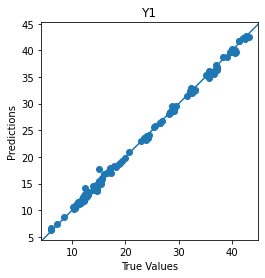

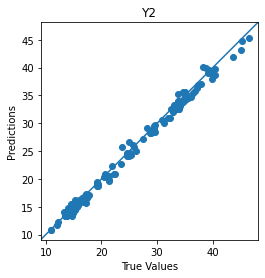

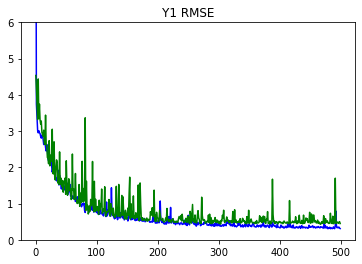

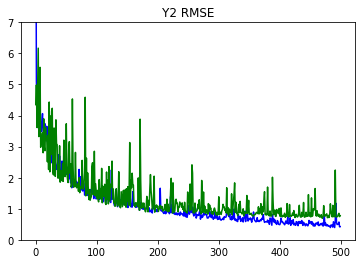

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)